In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install unidecode

In [3]:
%matplotlib inline  
import os
import pickle
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,concatenate,Dropout,BatchNormalization,add,Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import unidecode
from prettytable import PrettyTable
import gensim

nltk.download('stopwords')
nltk.download('wordnet')
stops = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
max_features = 300
rf_max_features = 200

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
project_folder = '/content/drive/My Drive/challenge/'
models_folder = project_folder+'models/'
quora_duplicate_questions = project_folder+'quora_duplicate_questions.tsv'
quora_pre_processed_file = project_folder+'quora_pre_processed.pre'
quora_bag_of_words_file = project_folder+'quora_simple_bag_of_words.bow'
quora_tf_idf_file = project_folder+'quora_tf_idf.tfidf'
quora_text_to_seq_file = project_folder+'text_to_seq.seq'
glove_embedding_text = project_folder+'glove.6B.300d.txt'

In [5]:
def handle_pickle(pickle_path, operation = "read", pickle_data = None):
    if operation == "read":
        try:
            with open(pickle_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print("Exception in loading pickle file {} due to the following exception {}".format(pickle_path,e))
            return None
    else:
        try:
            with open(pickle_path, "wb") as f:
                pickle.dump(pickle_data,f)
        except Exception as e:
            print("Exception in dumping pickle file {} due to the following exception {}".format(pickle_path,e))
            return None

In [6]:
def preprocess(text):
    # lower text
    text = str(text).lower()

    #unidecode text
    text = unidecode.unidecode(text)

    # handle contractions
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"ain\'t", "is not", text)
    
    # handle symbols and currencies
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)
    text = text.replace(",000,000", "m").replace(",000", "k").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")

    # remove symbols
    text = re.sub(r"[^A-Za-z0-9]", " ", text)

    # remove whitespace
    text = re.sub(r"[\s]+", " ", text)

    # Tokenize
    text = text.split()

    # Remove stop words and lemmatize
    text_list = []
    for w in text:
        if w not in stops:
            w_ =  WordNetLemmatizer().lemmatize(w, pos='v')
            if len(w_) > 2:
                text_list.append(w_)

    text = ' '.join(text_list)
    if len(text) == 0:
        return np.nan

    return text

In [7]:
def load_preprocessed_data(mode, source_frame, pre_processed_file, overwrite = False):
    try:
        preprocess_data = None
        if mode == 'train':
            if pre_processed_file.endswith('.pre'):   
                if not overwrite:
                    preprocess_data = handle_pickle(pre_processed_file)
            else:
                raise Exception("Invalid Preprocessed file {}".format(pre_processed_file))

        if preprocess_data is None:
            preprocess_data = source_frame.copy()
            preprocess_data['question1'] = preprocess_data['question1'].apply(lambda x: preprocess(x))
            preprocess_data['question2'] = preprocess_data['question2'].apply(lambda x: preprocess(x))
            preprocess_data = preprocess_data.dropna()

            if mode == 'train':
                handle_pickle(pre_processed_file, "write", preprocess_data)
            
        return preprocess_data[['question1','question2']],preprocess_data[['is_duplicate']]
            
    except Exception as e:
        raise Exception("Unable to do pre processing due to exception {}".format(e))

In [8]:
def load_bag_of_words_features(mode, source_data, bag_of_words_file, max_features = 250, overwrite = False):
    try:  
        if bag_of_words_file.endswith('.bow'):   
            bow_q1 = bow_q2 = bow_labels = count_vectorizer = None
            if mode == 'train':
                if not overwrite:
                    bow_q1, bow_q2, bow_labels, count_vectorizer = handle_pickle(bag_of_words_file)
            else:
                _, _, _, count_vectorizer = handle_pickle(bag_of_words_file)
        else:
            raise Exception("Invalid bag of words file {}".format(bag_of_words_file))

        if bow_q1 is None:
            x, y = source_data

            if mode == 'train':
                count_vectorizer = CountVectorizer(max_features=max_features)
                count_vectorizer.fit(pd.concat((x['question1'],x['question2'])).unique())
            
            bow_q1 = count_vectorizer.transform(x['question1'].values).toarray()
            bow_q2 = count_vectorizer.transform(x['question2'].values).toarray()
            bow_labels = np.asarray(y)

            if mode == 'train':
                handle_pickle(bag_of_words_file, "write", (bow_q1, bow_q2, bow_labels, count_vectorizer))
            
        return bow_q1, bow_q2, bow_labels, count_vectorizer
            
    except Exception as e:
        raise Exception("Unable to generate bag of words features due to exception {}".format(e))

In [9]:
def load_tfidf_features(mode, source_data, tfidf_file, max_features = 250, overwrite = False):
    try:  
        if tfidf_file.endswith('.tfidf'):   
            tfidf_q1 = tfidf_q2 = tfidf_labels = tfidf_vectorizer = None
            if mode == 'train':
                if not overwrite:
                    tfidf_q1, tfidf_q2, tfidf_labels, tfidf_vectorizer = handle_pickle(tfidf_file)
            else:
                _, _, _, tfidf_vectorizer = handle_pickle(tfidf_file)
        else:
            raise Exception("Invalid tfidf file {}".format(tfidf_file))

        if tfidf_q1 is None:
            x, y = source_data

            if mode == 'train':
                tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
                tfidf_vectorizer.fit(pd.concat((x['question1'],x['question2'])).unique())

            tfidf_q1 = tfidf_vectorizer.transform(x['question1'].values).toarray()
            tfidf_q2 = tfidf_vectorizer.transform(x['question2'].values).toarray()
            tfidf_labels = np.asarray(y)

            if mode == 'train':
                handle_pickle(tfidf_file, "write", (tfidf_q1, tfidf_q2, tfidf_labels, tfidf_vectorizer))
            
        return tfidf_q1, tfidf_q2, tfidf_labels, tfidf_vectorizer
            
    except Exception as e:
        raise Exception("Unable to generate tfidf features due to exception {}".format(e))

In [10]:
def load_text_to_sequences(mode, source_data, text_to_seq_file, max_features = 250, overwrite = False):
    try:  
        if text_to_seq_file.endswith('.seq'):   
            q1_sequences = q2_sequences = labels = keras_tokenizer = None
            if mode == 'train':
                if not overwrite:
                    q1_sequences, q2_sequences, labels, keras_tokenizer = handle_pickle(text_to_seq_file)
            else:
                _, _, _, keras_tokenizer = handle_pickle(text_to_seq_file)
        else:
            raise Exception("Invalid text to sequence file {}".format(text_to_seq_file))

        if q1_sequences is None:
            x, y = source_data

            if mode == 'train':
                keras_tokenizer = Tokenizer()
                keras_tokenizer.fit_on_texts(pd.concat((x['question1'],x['question2'])).unique())

            q1_sequences = keras_tokenizer.texts_to_sequences(x['question1'])
            q2_sequences = keras_tokenizer.texts_to_sequences(x['question2'])
            q1_sequences = pad_sequences(q1_sequences, maxlen=max_features)
            q2_sequences = pad_sequences(q2_sequences, maxlen=max_features)
            labels = np.asarray(y)

            if mode == 'train':
                handle_pickle(text_to_seq_file, "write", (q1_sequences, q2_sequences, labels, keras_tokenizer))
            
        return q1_sequences, q2_sequences, labels, keras_tokenizer
            
    except Exception as e:
        raise Exception("Unable to generate text to sequences due to exception {}".format(e))

In [11]:
# models using token embeddings
def getCustomModel(max_features,vocab_len,embedding_weights=None):

    inp_q1 = Input(shape=(max_features,), dtype=np.int32)
    inp_q2 = Input(shape=(max_features,), dtype=np.int32)   

    if embedding_weights is None:
        embed_layer = Embedding(input_dim=vocab_len, output_dim=300)
    else:
        embed_layer = Embedding(input_dim=vocab_len, output_dim=300, weights = [embedding_weights], trainable=False)

    q1 = embed_layer(inp_q1)
    q1 = LSTM(60)(q1)
    q1 = Dense(128, activation="relu")(q1)
    q1 = Dropout(0.2)(q1)
    q1 = BatchNormalization()(q1)
    q1 = Dense(64, activation="relu")(q1)
    q1 = Dropout(0.2)(q1)
    q1 = BatchNormalization()(q1)

    q2 = embed_layer(inp_q2)
    q2 = LSTM(60)(q2)
    q2 = Dense(128, activation="relu")(q2)
    q2 = Dropout(0.2)(q2)
    q2 = BatchNormalization()(q2)
    q2 = Dense(64, activation="relu")(q2)
    q2 = Dropout(0.2)(q2)
    q2 = BatchNormalization()(q2)

    output = concatenate([q1,q2])
    output = Dropout(0.3)(output)
    output = BatchNormalization()(output)
    output = Dense(128, activation="relu")(output)
    output = Dropout(0.4)(output)
    output = BatchNormalization()(output)
    output = Dense(1,activation = 'sigmoid')(output)

    model = keras.Model(inputs=[inp_q1,inp_q2],outputs=[output])

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
    return model

In [12]:
# models using sentence embeddings
def get_tf_hub_models(model_url):

    embed_layer = hub.KerasLayer(model_url,trainable=False)

    inp_q1 = Input(shape=[], dtype=tf.string)
    q1 = embed_layer(inp_q1)
    q1 = Dense(128, activation="relu")(q1)
    q1 = Dropout(0.2)(q1)
    q1 = BatchNormalization()(q1)
    q1 = Dense(64, activation="relu")(q1)
    q1 = Dropout(0.2)(q1)
    q1 = BatchNormalization()(q1)

    inp_q2 = Input(shape=[], dtype=tf.string)
    q2 = embed_layer(inp_q2)
    q2 = Dense(128, activation="relu")(q2)
    q2 = Dropout(0.2)(q2)
    q2 = BatchNormalization()(q2)
    q2 = Dense(64, activation="relu")(q2)
    q2 = Dropout(0.2)(q2)
    q2 = BatchNormalization()(q2)

    output = concatenate([q1,q2])
    output = Dropout(0.3)(output)
    output = BatchNormalization()(output)
    output = Dense(128, activation="relu")(output)
    output = Dropout(0.4)(output)
    output = BatchNormalization()(output)
    output = Dense(1,activation = 'sigmoid')(output)

    model = keras.Model(inputs=[inp_q1,inp_q2],outputs=[output])

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])    
    return model

In [13]:
def get_glove_embeddings(keras_tokenizer):
    embeddings_index = {}
    f = open(glove_embedding_text)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    embedding_matrix = np.zeros((len(keras_tokenizer.word_index) + 1, 300))
    for word, i in keras_tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [14]:
def plot_accuracy(model_name,history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(model_name+' - Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [15]:
def print_model_summary(model_name,model):
    print("\n",model_name,"\n")
    print(model.summary())
    print("\n")

In [16]:
def train_model(model_name,x_train,y_train,x_val,y_val,epochs,batch_size,retrain=False,max_features=None,vocab_size=None,embedding_weights=None):
    model = None
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    if retrain:
        model = keras.models.load_model(models_folder + model_name)
    else:
        if model_name == 'model_a':
            model = getCustomModel(max_features, vocab_size)
                
        elif model_name == 'model_b': 
            model = getCustomModel(max_features, vocab_size, embedding_weights)

        elif model_name == 'model_c':
            model = get_tf_hub_models('https://tfhub.dev/google/universal-sentence-encoder-large/5')
        
        elif model_name == 'model_d':
            model = get_tf_hub_models('https://tfhub.dev/google/Wiki-words-500-with-normalization/2')
         
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[callback], shuffle=True) 
    model.save(models_folder + model_name)
    with open(models_folder + model_name + '_history', "wb") as f:
        pickle.dump(history.history,f)

In [17]:
def load_model(model_name):
    model = None
    history = None
    try:
        model = keras.models.load_model(models_folder + model_name)
        print_model_summary(model_name,model)
        with open(models_folder + model_name + '_history', "rb") as f:
            history = pickle.load(f)
            plot_accuracy(model_name,history)
        print(model_name," model loaded")
        return model
    except Exception as e:
        raise Exception(model_name," model loading failed!! Please retrain by calling this method with overwrite = True")

In [18]:
def train_nn(epochs=20,batch_size=32,retrain=False,overwrite_data=False):
    print("Training started..")

    data = pd.read_csv(quora_duplicate_questions,sep='\t').dropna()
    rus = RandomUnderSampler(random_state=42,return_indices=False)
    data_x, data_y = rus.fit_sample(data[['question1','question2']], data[['is_duplicate']])
    data = pd.concat((pd.DataFrame(data=data_x,columns=['question1','question2']),pd.DataFrame(data=data_y,columns=['is_duplicate'])),axis=1)
    del data_x,data_y
    print("data size :", data.shape)
    print("\Labels category counts :")
    print(data['is_duplicate'].value_counts().to_string())
    preprocess_data = load_preprocessed_data('train', data, quora_pre_processed_file, overwrite_data)

    q1_sequences, q2_sequences, labels, keras_tokenizer = load_text_to_sequences('train', preprocess_data, quora_text_to_seq_file, max_features, overwrite_data)
    q1_train, _ , q2_train, _ , y_train_w, _ = train_test_split(q1_sequences, q2_sequences, labels.ravel(),test_size=0.2,random_state=42)
    q1_train, q1_val, q2_train, q2_val, y_train_w, y_val_w = train_test_split(q1_train, q2_train, y_train_w, test_size=0.1,random_state=42)
    vocab_size = len(keras_tokenizer.word_index) + 1
    glove_embeddings = None

    for model_name in ['model_a', 'model_b']:
        if model_name == 'model_b':
            glove_embeddings = get_glove_embeddings(keras_tokenizer)
        train_model(model_name,[q1_train, q2_train],y_train_w,[q1_val,q2_val],y_val_w,epochs,batch_size,retrain,max_features,vocab_size,glove_embeddings)

    del q1_sequences, q2_sequences, labels, keras_tokenizer, q1_train, q2_train, y_train_w, q1_val, q2_val, y_val_w, glove_embeddings

    x_train, _, y_train, _ = train_test_split(preprocess_data[0], preprocess_data[1],test_size=0.2,random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,random_state=42)

    for model_name in ['model_c', 'model_d']:
        train_model(model_name,[x_train['question1'], x_train['question2']],y_train,[x_val['question1'], x_val['question2']],y_val,epochs,batch_size,retrain)
    
    del x_train, y_train, x_val, y_val, preprocess_data

    print("Training complete...")

In [23]:
def train_rf_model(estimators = 80,overwrite_data=False):
    print("Training Random forest started..")

    preprocess_data = load_preprocessed_data('train', None, quora_pre_processed_file, False)

    bow_q1, bow_q2, bow_labels, count_vectorizer = load_bag_of_words_features('train', preprocess_data, quora_bag_of_words_file, rf_max_features, overwrite_data)
    rf_bow_x =  np.concatenate((bow_q1,bow_q2), axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(rf_bow_x, bow_labels.ravel(), test_size=0.2,random_state=42)
    rf_bow_model = RandomForestClassifier(n_estimators=estimators)
    rf_bow_model.fit(x_train,y_train)
    pickle.dump(rf_bow_model, open(models_folder + 'rf_bow', 'wb'))

    del bow_q1, bow_q2, bow_labels, count_vectorizer, rf_bow_x, x_train, x_test, y_train, y_test, rf_bow_model

    tfidf_q1, tfidf_q2, tfidf_labels, tfidf_vectorizer = load_tfidf_features('train', preprocess_data, quora_tf_idf_file, rf_max_features, overwrite_data)
    rf_tfidf_x =  np.concatenate((tfidf_q1, tfidf_q2), axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(rf_tfidf_x, tfidf_labels.ravel(), test_size=0.2,random_state=42)
    rf_tfidf_model = RandomForestClassifier(n_estimators=estimators)
    rf_tfidf_model.fit(x_train,y_train)
    pickle.dump(rf_tfidf_model, open(models_folder + 'rf_tfidf', 'wb'))

    print("Training Random forest completed..")

In [20]:
def generate_results():
    accuracy_report = []
    preprocess_data = load_preprocessed_data('train', None, quora_pre_processed_file, False)
    for model_name in ['model_a', 'model_b', 'model_c', 'model_d', 'rf_bow', 'rf_tfidf']:
        if model_name in ['rf_bow', 'rf_tfidf']:
            model = pickle.load(open(models_folder + model_name, 'rb'))
        else:
            model = load_model(model_name)   
        y_test = None
        y_pred = None
        if model_name in ['model_a', 'model_b']:
            q1_sequences, q2_sequences, labels, _ = load_text_to_sequences('train', None, quora_text_to_seq_file, max_features, False)
            _, q1_test, _, q2_test, _, y_test = train_test_split(q1_sequences, q2_sequences, labels.ravel(),test_size=0.2,random_state=42)
            y_prob = model.predict([q1_test, q2_test]) 
            y_pred = tf.greater(y_prob, .5)
            del q1_sequences, q2_sequences, labels, q1_test, q2_test, y_prob, model
        elif model_name in ['model_c', 'model_d']:
            _, x_test, _, y_test = train_test_split(preprocess_data[0], preprocess_data[1],test_size=0.2,random_state=42)
            y_prob = model.predict([x_test['question1'], x_test['question2']])
            y_pred = tf.greater(y_prob, .5)
            del x_test, y_prob, model
        elif model_name == 'rf_bow':
            bow_q1, bow_q2, bow_labels, _ = load_bag_of_words_features('train', preprocess_data, quora_bag_of_words_file, max_features, False)
            rf_bow_x =  np.concatenate((bow_q1,bow_q2), axis = 1)
            _, x_test, _, y_test = train_test_split(rf_bow_x, bow_labels.ravel(), test_size=0.2,random_state=42)
            y_pred = model.predict(x_test)
            del bow_q1, bow_q2, bow_labels, rf_bow_x, x_test, model
        elif model_name == 'rf_tfidf':
            tfidf_q1, tfidf_q2, tfidf_labels, _ = load_tfidf_features('train', preprocess_data, quora_tf_idf_file, max_features, False)
            rf_tfidf_x =  np.concatenate((tfidf_q1, tfidf_q2), axis = 1)
            _, x_test, _, y_test = train_test_split(rf_tfidf_x, tfidf_labels.ravel(), test_size=0.2,random_state=42)
            y_pred = model.predict(x_test)
            del tfidf_q1, tfidf_q2, tfidf_labels, rf_tfidf_x, x_test, model
        
        accuracy_report.append([model_name,
                                format(accuracy_score(y_test,y_pred)*100,'.2f'),
                                format(precision_score(y_test,y_pred)*100,'.2f'),
                                format(recall_score(y_test,y_pred)*100,'.2f'),
                                format(f1_score(y_test,y_pred)*100,'.2f')])
    return accuracy_report

In [21]:
def print_results(accuracy_report):
    print("Testing results:")
    t = PrettyTable(['Model','Acuracy','Precision','Recall','F1-Score'])
    for obj in accuracy_report:
        t.add_row([obj[0],obj[1],obj[2],obj[3],obj[4]])
    print(t)

In [ ]:
train_nn(epochs=10,batch_size=128,retrain=False,overwrite_data=True)

Training started..


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


data size : (298526, 3)
\Labels category counts :
1    149263
0    149263
Epoch 1/10
1677/1677 [==============================] - 361s 215ms/step - loss: 0.5732 - accuracy: 0.7016 - val_loss: 0.5165 - val_accuracy: 0.7409
Epoch 2/10
1677/1677 [==============================] - 360s 215ms/step - loss: 0.4807 - accuracy: 0.7687 - val_loss: 0.5133 - val_accuracy: 0.7497
Epoch 3/10
1677/1677 [==============================] - 362s 216ms/step - loss: 0.4222 - accuracy: 0.8029 - val_loss: 0.5051 - val_accuracy: 0.7539
Epoch 4/10
1677/1677 [==============================] - 362s 216ms/step - loss: 0.3696 - accuracy: 0.8324 - val_loss: 0.5289 - val_accuracy: 0.7513
Epoch 5/10
1677/1677 [==============================] - 362s 216ms/step - loss: 0.3195 - accuracy: 0.8582 - val_loss: 0.5585 - val_accuracy: 0.7494
Epoch 6/10
1677/1677 [==============================] - 363s 216ms/step - loss: 0.2791 - accuracy: 0.8794 - val_loss: 0.6030 - val_accuracy: 0.7501
Epoch 7/10
1677/1677 [================

INFO:tensorflow:Assets written to: /content/drive/My Drive/challenge/models/model_c/assets


Epoch 1/10
1677/1677 [==============================] - 21s 13ms/step - loss: 0.6390 - accuracy: 0.6383 - val_loss: 0.5815 - val_accuracy: 0.6887
Epoch 2/10
1677/1677 [==============================] - 21s 13ms/step - loss: 0.5881 - accuracy: 0.6832 - val_loss: 0.5604 - val_accuracy: 0.7047
Epoch 3/10
1677/1677 [==============================] - 21s 12ms/step - loss: 0.5702 - accuracy: 0.6974 - val_loss: 0.5499 - val_accuracy: 0.7115
Epoch 4/10
1677/1677 [==============================] - 21s 13ms/step - loss: 0.5567 - accuracy: 0.7088 - val_loss: 0.5377 - val_accuracy: 0.7203
Epoch 5/10
1677/1677 [==============================] - 21s 12ms/step - loss: 0.5458 - accuracy: 0.7169 - val_loss: 0.5323 - val_accuracy: 0.7230
Epoch 6/10
1677/1677 [==============================] - 21s 13ms/step - loss: 0.5385 - accuracy: 0.7234 - val_loss: 0.5253 - val_accuracy: 0.7277
Epoch 7/10
1677/1677 [==============================] - 21s 12ms/step - loss: 0.5304 - accuracy: 0.7298 - val_loss: 0.5290 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/challenge/models/model_d/assets


In [24]:
train_rf_model(estimators = 80,overwrite_data=True)

Training Random forest started..
Training Random forest completed..



 model_a 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     18359400    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 60)           86640       embedding[

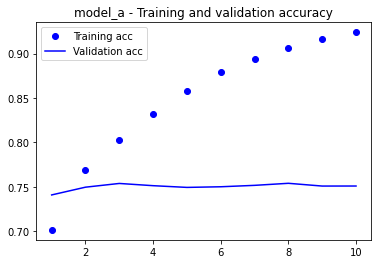

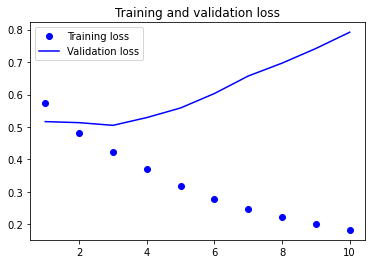

model_a  model loaded

 model_b 

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     18359400    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 60)           

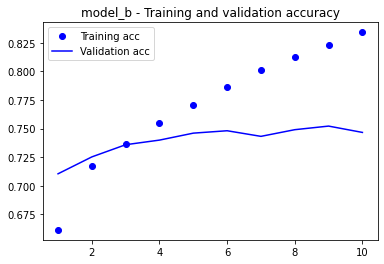

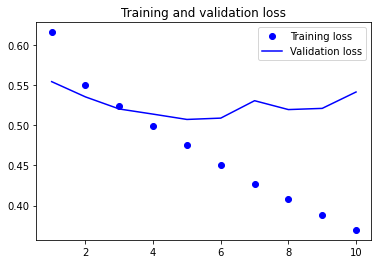

model_b  model loaded

 model_c 

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          147354880   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          

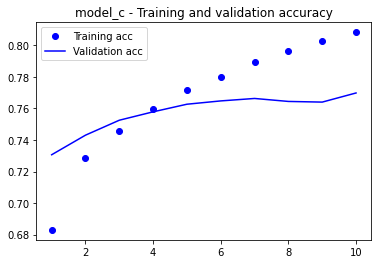

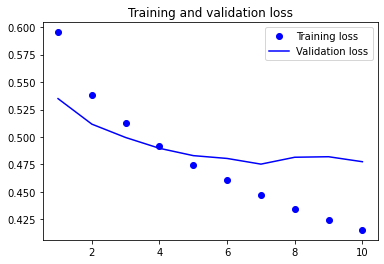

model_c  model loaded

 model_d 

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 500)          504687500   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 128)          

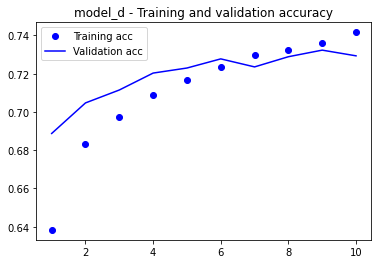

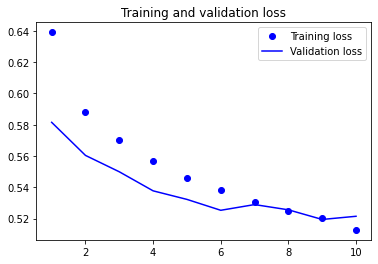

model_d  model loaded


In [25]:
accuracy_report = generate_results()

In [26]:
print_results(accuracy_report)

Testing results:
+----------+---------+-----------+--------+----------+
|  Model   | Acuracy | Precision | Recall | F1-Score |
+----------+---------+-----------+--------+----------+
| model_a  |  75.21  |   72.31   | 82.01  |  76.85   |
| model_b  |  74.66  |   73.82   | 76.71  |  75.24   |
| model_c  |  76.62  |   75.32   | 79.43  |  77.32   |
| model_d  |  72.82  |   69.34   | 82.19  |  75.22   |
|  rf_bow  |  69.17  |   65.71   | 80.62  |  72.41   |
| rf_tfidf |  69.92  |   67.14   | 78.44  |  72.35   |
+----------+---------+-----------+--------+----------+


In [27]:
from keras.utils.vis_utils import plot_model
for z in ['model_a', 'model_b', 'model_c', 'model_d']:
    modelz = keras.models.load_model(models_folder + z)
    plot_model(modelz, to_file=models_folder+z+'.png', show_shapes=True, show_layer_names=False)